In [20]:
from river import compose
from river import tree
from river import metrics
from river import preprocessing

In [21]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.ExtremelyFastDecisionTreeClassifier()   
)

In [22]:
metric = metrics.Accuracy()

In [23]:
# # training the model using only host based feature
# import csv
# with open('host_based_dataset.csv') as csv_file:
#     reader = csv.reader(csv_file)
#     next(csv_file)
#     for row in reader:
#         if row[1] == '-1':
#             continue
#         x = {
#             "f1" : float(row[3])
#         }
#         y = float(row[-1])
#         y_pred = model.predict_one(x)
#         metric = metric.update(y, y_pred)
#         model = model.learn_one(x, y)

In [24]:
# print(metric)

In [25]:
# from getFeaturesHost import getHostFeatures

In [30]:
# Making connection to mongoDB
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")

mydb = myclient["url_list"]
mycol = mydb["host_based_featuress"]

In [31]:
#Adding the dataset to mongodb
import csv
with open('host_based_dataset.csv') as csv_file:
    reader = csv.reader(csv_file)
    next(csv_file)
    for row in reader:
        x = {
            "url" : row[0],
            "duration" : row[1],
            "label" : row[2]
        }
        mycol.insert_one(x)


In [32]:
# training model by taking data from mongodb
cursor = mycol.find({})
while True:
    d = dict()
    try:
        d = cursor.next()
    except:
        break
    dur = d['duration']
    x = {
            "f1" : float(dur)
        }
    y = float(d['label'])
    y_pred = model.predict_one(x)
    metric = metric.update(y, y_pred)
    model = model.learn_one(x, y)
    # print(y_pred, y)
        

In [33]:
print(metric)

Accuracy: 72.31%


In [6]:
import pandas as pd

In [20]:
df1 = pd.read_csv("host_based_dataset.csv")
df2 = pd.read_csv("html_data.csv")
df3 = pd.read_csv("final_dataset.csv")

df1.head(10)

,url,duration,label
0,http://www.currysleather.com/,240,0
1,http://www.mcfc.co.uk/,309,0
2,https://whatsapp.blazagency.com/99e665748bd5bf...,12,1
3,https://pwcs-co.cf/?login=do,-1,1
4,https://messagerie-llebon-coins.com/,12,1
5,http://www.mclink.it/assoc/isp/fineng.html,266,0
6,https://nervousstudentllama.tumblr.com/ARU?id=...,204,1
7,http://royalmail.reschedule-missed-parcel.com/,12,1
8,http://www.britishtea.com/,288,0
9,http://www.mon-photo.com/,204,0


In [21]:
df2.head(10)

,url,no of iframe tags,no of hidden elements,no. script elements,presence of meta refresh tags,no of object tag,no of urls,presence of double documents,label
0,http://www.moviem.co.uk/,0,0,11,False,0,32,0,0
1,http://www.moviem.co.uk/,0,0,11,False,0,32,0,0
2,http://www.moviem.co.uk/,0,0,11,False,0,32,0,0
3,ttp://www.irisa.fr/Gowachin/,0,0,0,False,0,25,0,0
4,http://182.16.30.221/ap/signin?openid.pape.max...,0,0,7,False,0,11,0,1
5,http://portal.acm.org/,0,0,0,0,0,0,0,0
6,http://www.moviem.co.uk/,0,0,11,False,0,32,0,0
7,http://myidsignwithid.from-al.com/TEL/31d84713...,0,0,0,0,0,0,0,1
8,https://whatsapp.blazagency.com/99e665748bd5bf...,0,0,0,0,0,0,0,1
9,http://kontoopdatering.appleld.dk.opdatering.d...,0,0,0,0,0,0,0,1


In [22]:
df3.head(10)

,url,label
0,http://www.currysleather.com/,0
1,http://www.mcfc.co.uk/,0
2,https://whatsapp.blazagency.com/99e665748bd5bf...,1
3,https://pwcs-co.cf/?login=do,1
4,https://messagerie-llebon-coins.com/,1
5,http://www.mclink.it/assoc/isp/fineng.html,0
6,https://nervousstudentllama.tumblr.com/ARU?id=...,1
7,http://royalmail.reschedule-missed-parcel.com/,1
8,http://www.britishtea.com/,0
9,http://www.mon-photo.com/,0


In [119]:
# For host + content based features

from getFeaturesLexical import getLexicalFeatures

all_features_list = []
for index, row in df2.iterrows():
    url = row['url']
    # print(url)
    label = row['label']
    all_features = [url]
    # lexical_features = getLexicalFeatures(url)

    host_features = df1['duration'].where(df1['url'] == url)
    host_features = host_features.dropna()
    host_features = host_features.values.tolist()

    

    if len(host_features) == 0:
        host_features.append(0)
    else:
        if host_features[0] == -1:
            host_features[0] = 0  

    while len(host_features) > 1:
        host_features.pop()
    content_features = row.values.tolist()

    

    all_features = host_features + content_features

    
    all_features_list.append(all_features)

# print(len(all_features_list[0]))
# print(all_features_list[:5])

featureSet = pandas.DataFrame(columns=('duration','url','number_of_iframe_tags','number_of_hidden_elements','number_of_script_elements','number_of_meta_refresh_tags','number_of_object_tags','number_of_urls','presence_of_double_document','label'))

# lfeatureSet.columns)
for i in range(len(all_features_list)):
    # print(len(all_features_list[i]))

    all_features_list[i] = [0 if i == 'False' else i for i in all_features_list[i]]
    all_features_list[i] = [1 if i == 'True' else i for i in all_features_list[i]]

    featureSet.loc[i] = all_features_list[i]

In [120]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


X = featureSet.drop(['url', 'label'], axis=1).values
y = featureSet['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


y_trainn=y_train.astype('int')
y_testt=y_test.astype('int')

X_trainn=X_train.astype('int')
X_testt=X_test.astype('int')

model = SVC(kernel='linear')
model.fit(X_trainn, y_trainn)
score = model.score(X_testt, y_testt)
print(score)

from joblib import dump, load
dump(model, 'version1_host_cont.pkl')

# model = load('filename.pkl')

0.7714285714285715


['version1_host_cont.pkl']

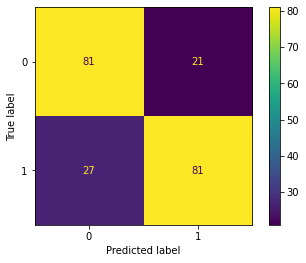

In [121]:
matrix = plot_confusion_matrix(model, X_testt, y_testt)

In [122]:
precision = 81/(21 + 81)
precision

0.7941176470588235

In [123]:
recall = 81/(27 + 81)
recall

0.75

In [124]:
# For Lexical + Host based features

from getFeaturesLexical import getLexicalFeatures

all_features_list = []
for index, row in df2.iterrows():
    url = row['url']
    # print(url)
    label = row['label']
    all_features = [url]
    lexical_features = getLexicalFeatures(url)

    host_features = df1['duration'].where(df1['url'] == url)
    host_features = host_features.dropna()
    host_features = host_features.values.tolist()

    

    if len(host_features) == 0:
        host_features.append(0)
    else:
        if host_features[0] == -1:
            host_features[0] = 0  

    while len(host_features) > 1:
        host_features.pop()
    # content_features = row.values.tolist()

    

    all_features = [url] + lexical_features + host_features + [label]

    
    all_features_list.append(all_features)

# print(len(all_features_list[0]))
# print(all_features_list[:5])

featureSet = pandas.DataFrame(columns=('url','url_length','dots_count','suspicious_tld','hyphen_count','subdir_count','domain_length','ip_present','double_slash_count','url_shortening_service','count_subdomain_domain_tokens','count_queries','count_at_symbol','presence_of_%20','digit/letter','special_char','duration','label'))

# lfeatureSet.columns)
for i in range(len(all_features_list)):
    # print(len(all_features_list[i]))

    all_features_list[i] = [0 if i == 'False' else i for i in all_features_list[i]]
    all_features_list[i] = [1 if i == 'True' else i for i in all_features_list[i]]

    featureSet.loc[i] = all_features_list[i]







    
    
    

In [125]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


X = featureSet.drop(['url', 'label'], axis=1).values
y = featureSet['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


y_trainn=y_train.astype('int')
y_testt=y_test.astype('int')

X_trainn=X_train.astype('int')
X_testt=X_test.astype('int')

model = SVC(kernel='linear')
model.fit(X_trainn, y_trainn)
score = model.score(X_testt, y_testt)
print(score)

from joblib import dump, load
dump(model, 'version1_lex_host.pkl')

# model = load('filename.pkl')

0.8285714285714286


['version1_lex_host.pkl']

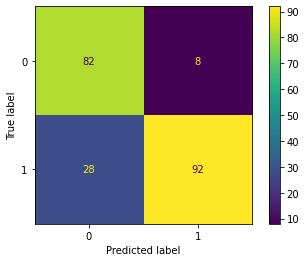

In [126]:
matrix = plot_confusion_matrix(model, X_testt, y_testt)

In [128]:
precision = 92/(92 + 8)
print(precision)
recall = 92/(92 + 28)
recall

0.92


0.7666666666666667